In [ ]:
from google.colab import files
import os

# This prompts you to upload a file
print('Please upload your kaggle.json file:')
files.upload()

# Set up the Kaggle directory and move the API key into it
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset using the Kaggle API
!kaggle datasets download -d akashdogra/cic-iot-2023

# Unzip the downloaded file
!unzip -q cic-iot-2023.zip

# Create a new directory (folder)
!mkdir data_folder

# Move all 'part-' files into the new folder
!mv part-* data_folder/

print("\n--- Step 1 Complete: Data downloaded and organized into 'data_folder' ---")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/akashdogra/cic-iot-2023
License(s): unknown
 96% 2.65G/2.77G [00:08<00:00, 155MB/s] 
100% 2.77G/2.77G [00:08<00:00, 365MB/s]

--- Step 1 Complete: Data downloaded and organized into 'data_folder' ---


In [ ]:
import pandas as pd
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# This function is needed to identify the correct labels during loading
def simplify_labels(df):
    category_dict = {
        'Benign': 'Benign',
        'BenignTraffic': 'Benign', # Fix for the dataset
        'DDoS-RSTFINFlood': 'DDOS', 'DDOS-PSHACK_Flood': 'DDOS',
        'DDoS-SYN_Flood': 'DDOS', 'DDoS-UDP_Flood': 'DDOS', 'DDoS-TCP_Flood': 'DDOS',
        'DDoS-ICMP_Flood': 'DDOS', 'DDoS-SynonymousIP_Flood': 'DDOS', 'DDoS-ACK_Fragmentation': 'DDOS',
        'DDoS-UDP_Fragmentation': 'DDOS', 'DDoS-ICMP_Fragmentation': 'DDOS', 'DDoS-SlowLoris': 'DDOS',
        'DDoS-HTTP_Flood': 'DDOS', 'DoS-SYN_Flood': 'DoS', 'DoS-UDP_Flood': 'DoS',
        'DoS-TCP_Flood': 'DoS', 'DoS-HTTP_Flood': 'DoS'
    }
    if 'label' in df.columns:
        df['label'] = df['label'].str.strip().map(lambda x: category_dict.get(x, x))
    return df

# --- Pass 1: Count Samples (Low Memory) ---
print("--- Starting Pass 1: Counting samples... ---")
dataset_path = './data_folder/'
all_csv_files = sorted(glob.glob(os.path.join(dataset_path, "*.csv")))
chunk_size = 100000
num_benign_samples = 0
num_attack_samples = 0

for file in all_csv_files:
    try:
        for chunk in pd.read_csv(file, chunksize=chunk_size, low_memory=False):
            chunk = simplify_labels(chunk)
            num_benign_samples += len(chunk[chunk['label'] == 'Benign'])
            num_attack_samples += len(chunk[chunk['label'].isin(['DDOS', 'DoS'])])
    except Exception as e:
        print(f"  Error processing {os.path.basename(file)}: {e}")

print(f"Found {num_attack_samples} attack samples and {num_benign_samples} benign samples.")

# --- Pass 2: Load and Downsample Simultaneously ---
print("\n--- Starting Pass 2: Loading and downsampling data... ---")
if num_attack_samples == 0 or num_benign_samples == 0:
    print("Error: One of the classes has 0 samples. Cannot proceed. Check simplify_labels function.")
else:
    sampling_rate = num_benign_samples / num_attack_samples
    if sampling_rate > 1: sampling_rate = 1

    df_list = []
    for file in all_csv_files:
        try:
            for chunk in pd.read_csv(file, chunksize=chunk_size, low_memory=False):
                chunk = simplify_labels(chunk)

                benign_chunk = chunk[chunk['label'] == 'Benign']
                if not benign_chunk.empty:
                    df_list.append(benign_chunk)

                attack_chunk = chunk[chunk['label'].isin(['DDOS', 'DoS'])]
                if not attack_chunk.empty:
                    sampled_attack = attack_chunk.sample(frac=sampling_rate, random_state=42)
                    df_list.append(sampled_attack)
        except Exception as e:
            print(f"  Error processing {os.path.basename(file)}: {e}")

    print("\nCombining all balanced data...")
    full_df = pd.concat(df_list, ignore_index=True)
    full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # --- THIS IS THE NEW, CRITICAL FIX ---
    print("\nConsolidating 'DDOS' and 'DoS' into 'Attack'...")
    full_df['label'] = full_df['label'].replace({'DDOS': 'Attack', 'DoS': 'Attack'})

    print(f"\nSampling complete. New balanced dataset shape: {full_df.shape}")
    print("Label distribution in the new balanced DataFrame:")
    print(full_df['label'].value_counts()) # Will now show 'Attack' and 'Benign'

    # --- Preprocessing (from your base paper) ---
    print("\n--- Preprocessing data... ---")
    full_df.columns = full_df.columns.str.strip().str.lower().str.replace(' ', '_')
    cols_to_drop = ['flow_id', 'source_ip', 'destination_ip', 'timestamp', 'unnamed:_0']
    full_df.drop(columns=[col for col in cols_to_drop if col in full_df.columns], inplace=True, errors='ignore')
    full_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    for col in full_df.select_dtypes(include=np.number).columns:
        full_df[col].fillna(full_df[col].mean(), inplace=True)

    le = LabelEncoder()
    full_df['label'] = le.fit_transform(full_df['label'])
    # We print the mapping to be 100% sure
    print(f"\nLabels encoded. 'Attack' is {le.transform(['Attack'])[0]}, 'Benign' is {le.transform(['Benign'])[0]}.")

    X = full_df.drop(columns=['label'])
    y = full_df['label']

    # --- Data Splitting and Scaling (from your base paper) ---
    print("\n--- Splitting and Scaling Data ---")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    print(f"Data split into 70% training ({len(X_train)} rows) and 30% testing ({len(X_test)} rows).")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("\n--- Step 2 Complete: Data is balanced, prepared, and split. ---")

--- Starting Pass 1: Counting samples... ---
Found 37980543 attack samples and 1098195 benign samples.

--- Starting Pass 2: Loading and downsampling data... ---

Combining all balanced data...

Consolidating 'DDOS' and 'DoS' into 'Attack'...

Sampling complete. New balanced dataset shape: (2196389, 47)
Label distribution in the new balanced DataFrame:
label
Benign    1098195
Attack    1098194
Name: count, dtype: int64

--- Preprocessing data... ---


/tmp/ipython-input-639741973.py:87: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_df[col].fillna(full_df[col].mean(), inplace=True)



Labels encoded. 'Attack' is 0, 'Benign' is 1.

--- Splitting and Scaling Data ---
Data split into 70% training (1537472 rows) and 30% testing (658917 rows).

--- Step 2 Complete: Data is balanced, prepared, and split. ---


Recursive Feature Elimination with Cross-Validation (RFECV

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
# Import RFECV
from sklearn.feature_selection import RFECV
# We will use DecisionTree as the "estimator" for RFECV because it's fast
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
import warnings

# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')

# --- Part 1: Automatic Feature Selection with RFECV ---

print("--- Starting Automatic Feature Selection with RFECV... ---")
print("(This may take a long time, as it's training many models...)")

# We use a fast Decision Tree as the "engine" for RFECV
estimator = DecisionTreeClassifier(random_state=42)
# Set up RFECV to test features and use 3-fold cross-validation
# n_jobs=-1 uses all available cores
rfecv_selector = RFECV(
    estimator=estimator,
    step=1, # Remove 1 feature at a time
    cv=StratifiedKFold(3), # Use 3-fold cross-validation
    scoring='accuracy', # The metric to optimize
    n_jobs=-1
)

# Fit RFECV to the balanced, scaled training data
rfecv_selector.fit(X_train_scaled, y_train)

# --- Get the Results of RFECV ---
optimal_num_features = rfecv_selector.n_features_
print(f"\n--- RFECV Complete: Found {optimal_num_features} as the optimal number of features. ---")

# Get the indices of the selected features
optimal_indices = rfecv_selector.get_support(indices=True)
# Get the names of the selected features
optimal_feature_names = X.columns[optimal_indices]
print("\n--- Optimal Features Selected ---")
print(optimal_feature_names.tolist())

# Create the new, optimized training and testing sets
X_train_selected = rfecv_selector.transform(X_train_scaled)
X_test_selected = rfecv_selector.transform(X_test_scaled)
print(f"Feature selection complete. New data shape: {X_train_selected.shape}")


# --- Part 2: Train and Evaluate All Models ---

# Define the classifiers from your base paper
classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

results = []
# Find the correct labels from the 'le' object
try:
    ATTACK_LABEL = np.where(le.classes_ == 'Attack')[0][0]
    BENIGN_LABEL = np.where(le.classes_ == 'Benign')[0][0]
    print(f"\nMetrics labels set: 'Attack' is {ATTACK_LABEL}, 'Benign' is {BENIGN_LABEL}.")
except Exception as e:
    print(f"CRITICAL ERROR: Could not find 'Attack'/'Benign' labels. {e}")
    ATTACK_LABEL = 0
    BENIGN_LABEL = 1

# This list defines the two experiments we will run
experiments_to_run = {
    "All Features": (X_train_scaled, X_test_scaled, X_train_scaled.shape[1]),
    f"RFECV (Auto-Selected)": (X_train_selected, X_test_selected, optimal_num_features)
}

print("\n--- Training and Evaluating Models ---")

for fs_name, (X_train_data, X_test_data, num_features) in experiments_to_run.items():
    print(f"\n--- Testing with '{fs_name}' ({num_features} features) ---")

    for clf_name, clf in classifiers.items():
        print(f"  Training {clf_name}...")
        start_time = time.time()

        clf.fit(X_train_data, y_train)
        predictions = clf.predict(X_test_data)

        # Calculate all metrics
        tn, fp, fn, tp = confusion_matrix(y_test, predictions, labels=[BENIGN_LABEL, ATTACK_LABEL]).ravel()
        accuracy = (tp+tn) / (tp+tn+fp+fn) if (tp+tn+fp+fn) > 0 else 0
        precision = tp / (tp+fp) if (tp+fp) > 0 else 0
        recall_tpr = tp / (tp+fn) if (tp+fn) > 0 else 0
        specificity_tnr = tn / (tn+fp) if (tn+fp) > 0 else 0
        fpr = fp / (fp+tn) if (fp+tn) > 0 else 0
        fnr = fn / (fn+tp) if (fn+tp) > 0 else 0
        f1 = 2 * (precision * recall_tpr) / (precision + recall_tpr) if (precision + recall_tpr) > 0 else 0

        results.append({
            'Classifier': clf_name,
            'Feature selection method': fs_name,
            'No. of features': num_features,
            'Accuracy': accuracy * 100, # Show as percentage
            'Precision': precision,
            'Recall or TPR': recall_tpr,
            'Specificity or TNR': specificity_tnr,
            'FPR': fpr,
            'FNR': fnr,
            'F1-score': f1
        })

        print(f"    -> {clf_name} Accuracy: {accuracy:.4f} (Time: {time.time() - start_time:.2f}s)")

# --- Final Step: Display the Results Table (like Table 11) ---

results_df = pd.DataFrame(results)
final_columns = [
    'Classifier', 'Feature selection method', 'No. of features', 'Accuracy', 'Precision',
    'Recall or TPR', 'Specificity or TNR', 'FPR', 'FNR', 'F1-score'
]
final_table = results_df[final_columns].sort_values(by=['Classifier', 'Accuracy'], ascending=[True, False])

pd.set_option('display.precision', 4)
pd.set_option('display.width', 150)

print("\n\n--- FINAL PERFORMANCE TABLE ---")
print(final_table.to_string(index=False))

--- Starting Automatic Feature Selection with RFECV... ---
(This may take a long time, as it's training many models...)

--- RFECV Complete: Found 5 as the optimal number of features. ---

--- Optimal Features Selected ---
['flow_duration', 'rst_count', 'iat', 'number', 'variance']
Feature selection complete. New data shape: (1537472, 5)

Metrics labels set: 'Attack' is 0, 'Benign' is 1.

--- Training and Evaluating Models ---

--- Testing with 'All Features' (46 features) ---
  Training Decision Tree...
    -> Decision Tree Accuracy: 0.9999 (Time: 43.41s)
  Training Random Forest...
    -> Random Forest Accuracy: 1.0000 (Time: 323.66s)
  Training KNN...
    -> KNN Accuracy: 0.9999 (Time: 1113.30s)
  Training XGBoost...
    -> XGBoost Accuracy: 1.0000 (Time: 4.49s)

--- Testing with 'RFECV (Auto-Selected)' (5 features) ---
  Training Decision Tree...
    -> Decision Tree Accuracy: 1.0000 (Time: 5.24s)
  Training Random Forest...
    -> Random Forest Accuracy: 1.0000 (Time: 116.06s)
  T

--- Generating Final Summary Graph ---


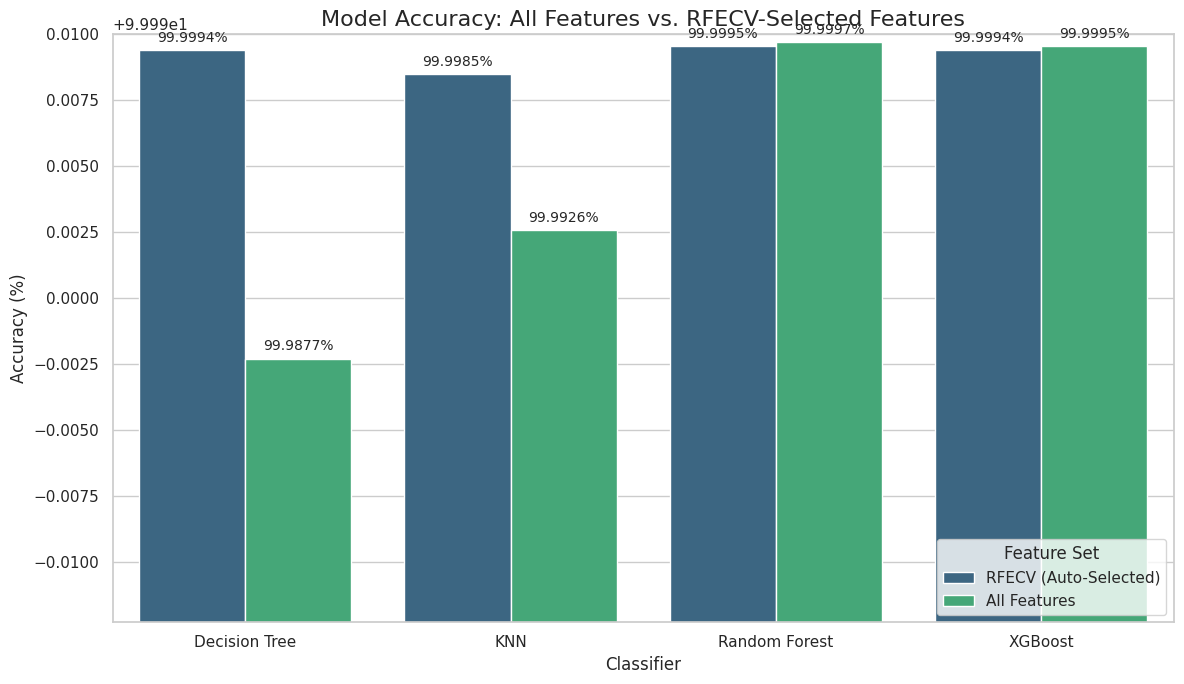


--- Graph Generation Complete ---


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# This script assumes 'final_table' (a DataFrame) exists in memory
# from the previous step.

print("--- Generating Final Summary Graph ---")

# Set the style for the plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

# Create the grouped bar chart
# 'Classifier' is on the x-axis
# 'Accuracy' is on the y-axis
# 'Feature selection method' determines the color of the bars (the groups)
g = sns.barplot(
    data=final_table,
    x='Classifier',
    y='Accuracy',
    hue='Feature selection method',
    palette='viridis' # Color palette for the two groups
)

# Set titles and labels
plt.title('Model Accuracy: All Features vs. RFECV-Selected Features', fontsize=16)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xlabel('Classifier', fontsize=12)

# Adjust the y-axis to zoom in on the high accuracy scores
min_accuracy = final_table['Accuracy'].min()
# Start the y-axis just below the lowest accuracy to show the tiny differences
plt.ylim(bottom=max(99.8, min_accuracy - 0.01), top=100.00)

# Add a legend
plt.legend(title='Feature Set', loc='lower right')

# Add the accuracy values (labels) on top of each bar
for p in g.patches:
    g.annotate(
        f"{p.get_height():.4f}%",   # Format the label to 4 decimal places
        (p.get_x() + p.get_width() / 2., p.get_height()), # Position
        ha='center',
        va='center',
        xytext=(0, 9),             # Offset 9 points vertically
        textcoords='offset points',
        fontsize=10
    )

# Show the plot
plt.tight_layout()
plt.show()

print("\n--- Graph Generation Complete ---")